# BIAS IN DATA: Analysis of toxicity in the Wikipedia Talk corpus

People can leave comments on Wikipedia pages. Sometimes, these comments might be toxic. 

Wikipedia Talk corpus have a dataset with a sample of comments that have been annotated by humans with a toxicity score ranging from -2 (very toxic) to 2 (very healthy).

In this analysis, we attempt to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.

- Overview of the research project that : https://meta.wikimedia.org/wiki/Research:Detox 
- Dataset description and schemas: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release 


## Step 1: Download the Toxicity dataset

In [488]:
import urllib

In [489]:
# download annotated comments and annotations
# original code: https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb

ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539' #toxicity_annotations.tsv
ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' # -O toxicity_annotated_comments.tsv
WORKER_DEMOGRAPHICS_URL = 'https://ndownloader.figshare.com/files/7640581' # -O toxicity_worker_demographics.tsv


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(ANNOTATED_COMMENTS_URL, 'toxicity_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'toxicity_annotations.tsv')
download_file(WORKER_DEMOGRAPHICS_URL, 'toxicity_worker_demographics.tsv')

## Step 2: Load tables using pandas

In [490]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [491]:
# Loading tables into pandas dataframe
toxicity_annotations = pd.read_csv("toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("toxicity_annotated_comments.tsv", delimiter="\t")
toxicity_worker_demographics = pd.read_csv("toxicity_worker_demographics.tsv", delimiter="\t")

Inspect tables

In [492]:
toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [493]:
toxicity_annotated_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [494]:
toxicity_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


## EDA

The annotators scored the comments based on the following scale:
(2) very healthy, (1) healthy, (0) neutral, (-1) toxic, (-2) very toxic.

Most scores given by the annotators were non-toxic. The most common score was zero, which means neutral. 



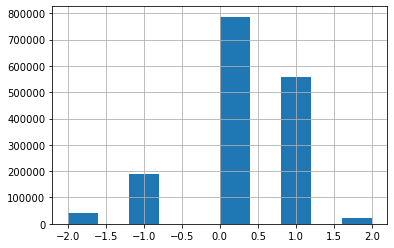

In [496]:
#plot
plt.hist(toxicity_annotations['toxicity_score'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_toxicity_score.jpg')

If a toxicity score is below zero (-1 or -2), then a comment is labeled as toxic (1).

If a toxicity score is non-negative (0, 1, or 2), then a comment is labeled as non-toxic (0).

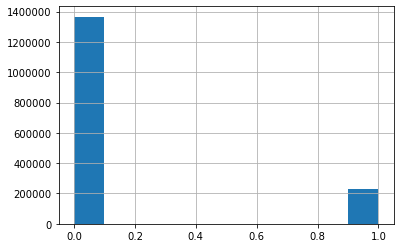

In [497]:
#plot
plt.hist(toxicity_annotations['toxicity'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_toxicity.jpg')

We would assume that some questions were given different scores by different annotators (disagreement between annotators). 

We take the standard deviation of the toxicity score to look at the disagreement. The graph below shows that most question had at least one annotator that had a different score than the others.

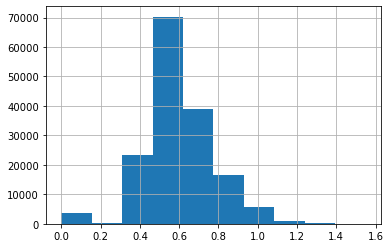

In [498]:
disagreement = toxicity_annotations[['rev_id','toxicity_score' ]].groupby('rev_id').std().sort_values(by='toxicity_score')


#plot
plt.hist(disagreement['toxicity_score'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_toxicityscore_disagreement.jpg')

# Step 3: Scientific Questions

In [499]:
import scipy

In [500]:
# joining datasets
joined_annotations = toxicity_annotations.set_index('worker_id', drop=False).join( toxicity_worker_demographics.set_index('worker_id', drop=False), rsuffix="_r")
joined_disagreement = joined_annotations.set_index('rev_id', drop=False).join( disagreement, rsuffix="_disagreement").reset_index(drop=True)
joined_disagreement.head()

,rev_id,worker_id,toxicity,toxicity_score,worker_id_r,gender,english_first_language,age_group,education,toxicity_score_disagreement
0,2232.0,405,0,1.0,405.0,male,0.0,30-45,masters,0.699206
1,2232.0,680,0,0.0,680.0,male,0.0,18-30,masters,0.699206
2,2232.0,723,0,0.0,723.0,female,0.0,30-45,bachelors,0.699206
3,2232.0,772,0,1.0,772.0,male,0.0,18-30,bachelors,0.699206
4,2232.0,1508,0,1.0,1508.0,female,1.0,45-60,hs,0.699206


## Do native English speakers annotators label comments more harshly (more toxic) than non-native spearkers? 

English is a difficult language and people can have different levels of fluency. A non-native English speaker may have quite good comprehension of English, but there might be some nuances in the language that are probably not as trivial to a non-native speakers as it is to native speakers (e.g., identifying toxicity in speech). 

The analysis below tries to identify:
- Is there a balance in the population of native and non-native speakers in Wikipedia Corpus?
- Is there a difference in scores given by these two populations?

We separate the population between native and non-native. The non-native population is more than 4 times larger than the native population. 

<b>The population of native and non-native speakers is clearly not balanced. Non-native speakers are overrepresented. </b>

native speakers: 666
non-native speakers: 2925


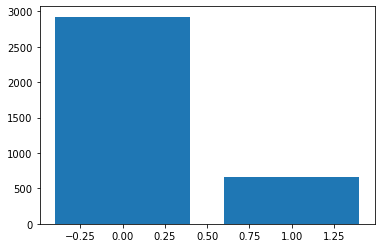

In [501]:
# separating population of native and non-native speakers
native = joined_disagreement[joined_disagreement['english_first_language'] == 1]
non_native = joined_disagreement[joined_disagreement['english_first_language'] == 0]

size_natives = len(native['worker_id'].unique())
size_non_natives = len(non_native['worker_id'].unique())

print("native speakers: " + str(size_natives) )
print("non-native speakers: " + str(size_non_natives) )
#joined_disagreement.groupby('english_first_language')['worker_id'].nunique().plot(kind='bar')

language_dist = joined_disagreement.groupby('english_first_language')['worker_id'].nunique()
# plotting gender distribution
#gender_dist = gender.groupby('gender')['worker_id'].nunique()
plt.bar(language_dist.index, language_dist.values)

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('language_distribution.jpg')

We look at the mean toxicity score and the mean toxicity of each group. And we find that the means are slightly different. Native speakers have a toxicity mean (percentage of questions that got a toxic or very toxic label) is 15.2% vs 14.4% non-native speakers.

In [502]:
joined_disagreement[['english_first_language', 'toxicity']].groupby('english_first_language').agg(['mean', 'count'])

toxicity         
                            mean    count
english_first_language                   
0.0                     0.144376  1113162
1.0                     0.152207   233793

However, is this small difference significant enough for us to say that there is a difference between those groups? 

To answer that, we visualize the distribution of those groups and we do a statistical test.

In [503]:
# getting the mean of toxic comments score
native_mean = native.groupby('worker_id').mean()[['toxicity', 'toxicity_score', 'english_first_language']]
non_native_mean = non_native.groupby('worker_id').mean()[['toxicity', 'toxicity_score', 'english_first_language']]

Below there are plots of percentage scores of users. Those percentage scores represent the percentage of comments labeled as toxic by the annotators (i.e., 1 means 100% of comments annotated by the annotator were labeled as toxic.)

We compare the distribution of those percentage scores for native and non-native speakers. 

The distributions seem to have a similar shape (almost Gaussian distribution), however, native speakers seem to have a longer right-tail leaning more towards toxic labels.  

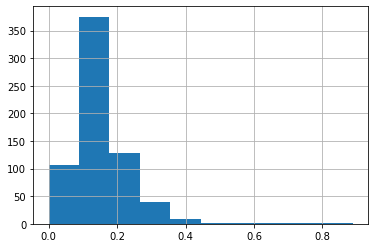

In [504]:
#plot
plt.hist(native_mean['toxicity'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_percentage_toxicity_native.jpg')

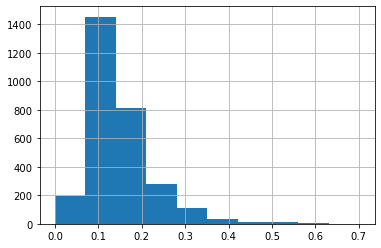

In [505]:
#plot
plt.hist(non_native_mean['toxicity'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_percentage_toxicity_nonnative.jpg')

We are going do the Manwhitney test to identify if there is a difference in the native and non-native population. This is a Statistical test that is appropriate to compare populations of different sizes. 
https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

Basically, we are trying to compare if native speakers label a comment as toxic just as much as non-native speakers, or if there is a statistically significant difference.

We know that native speakers have a toxicity mean of 15.2% while non-native speakers have a 14.4% toxicity mean. Thefore, our hypothesis is that <b>native speakers give more toxic labels to comments than non-native speakers</b>. 


####  H0: Native speakers give fewer (or as many) toxic labels than Non-Native speakers
- Native speakers <= Non-Native speakers

####  H1: Native speakers give a greater amount of toxic labels than Non-Native speakers
- Native speakers > Non-Native speakers



In [506]:
scipy.stats.mannwhitneyu(native_mean['toxicity'], non_native_mean['toxicity'] , use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=1021279.0, pvalue=0.025182791870197403)

After performing the test, we get a p-value smaller than 0.05, which means that we may <b>reject the null hypothesis</b> (i.e., we reject the hypothesis that native speakers label comments with the same or smaller toxicity score as non-native speakers). This seems to indicate that native speakers have scores that are statistically significantly greater than the scores given by non-native speakers in the toxicity scale. 

<b>Therefore, we conclude that native speakers are harsher than non-native speakers when annotating comments. </b>

## Does the annotator's gender affect the toxicity score? 

A person's gender influences how they experience the world. This may be factor that affects how an annotator scores a comment as toxic or non-toxic.

In this analysis, we try to answer the following questions:
- Are the genders of annotators in the Wikipedia Corpus balanced?
- Do different genders score comments differently? 

In [507]:
# filling missing gender information with "not disclosed"
gender = joined_disagreement.fillna({'gender': 'not disclosed'})
gender.head()

,rev_id,worker_id,toxicity,toxicity_score,worker_id_r,gender,english_first_language,age_group,education,toxicity_score_disagreement
0,2232.0,405,0,1.0,405.0,male,0.0,30-45,masters,0.699206
1,2232.0,680,0,0.0,680.0,male,0.0,18-30,masters,0.699206
2,2232.0,723,0,0.0,723.0,female,0.0,30-45,bachelors,0.699206
3,2232.0,772,0,1.0,772.0,male,0.0,18-30,bachelors,0.699206
4,2232.0,1508,0,1.0,1508.0,female,1.0,45-60,hs,0.699206


Our data contains 4 different classifications for gender: male, female, other, and not disclosed (for missing data). 

Looking at the distribution of the data, we notice that <b>the genders are not balanced</b>. Males represent more than 54% of the population of annotators; 29.3% of the annotators are female (the second largest group); 16.5% did not disclose their gender; an less than 0.1% are non-binary (other). 

gender
female           0.293653
male             0.541037
not disclosed    0.165078
other            0.000233
Name: worker_id, dtype: float64

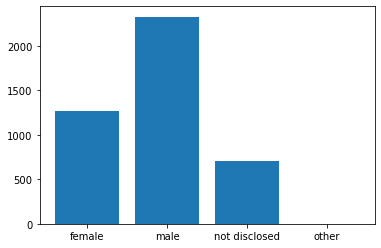

In [508]:
# plotting gender distribution
gender_dist = gender.groupby('gender')['worker_id'].nunique()
gender_plot = plt.bar(gender_dist.index, gender_dist.values)

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('gender_distribution.jpg')

# calculation percentage of each gender
dist = gender.groupby('gender')['worker_id'].nunique()
dist/dist.sum()



Next, we want to check if there are differences in the scores given by different genders. Thus, we calculate the mean percentage toxicity* per gender. 

The means seem different between the different groups of genders. 

*Percentage toxicity represents the percentage of comments that got a toxic score during annotation. 

In [509]:
gender[['gender', 'toxicity']].groupby('gender').agg(['mean', 'count'])

toxicity        
                   mean   count
gender                         
female         0.157093  457346
male           0.139886  889251
not disclosed  0.142265  251334
other          0.164804     358

Because female and male are our largest populations, we will focus the remainder of the analysis on those two gender classifications. We want to find out if the difference in annotation between this two genders is significant. 

First, we look at the distribution for the toxicity scores given by males and females. The distributions look similar.

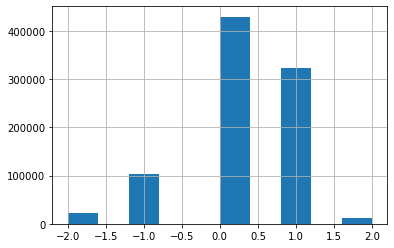

In [510]:
# separating population of gender
male = joined_disagreement[joined_disagreement['gender'] == 'male']
female = joined_disagreement[joined_disagreement['gender'] == 'female']


male_hist = plt.hist(male['toxicity_score'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_toxicityscore_male.jpg')

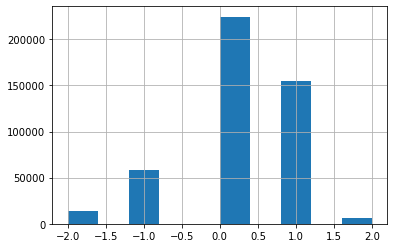

In [511]:
female_hist = plt.hist(female['toxicity_score'])
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_toxicityscore_female.jpg')

Next, we plot the distribution of percentage toxicity (percentage of comments that were annotated with a toxic score).

The distributions look different with females seeming to have more toxic annotations. 

In [512]:
# getting the mean of toxic comments score
male_mean = male.groupby('worker_id').mean()[['toxicity']]
female_mean = female.groupby('worker_id').mean()[['toxicity']]

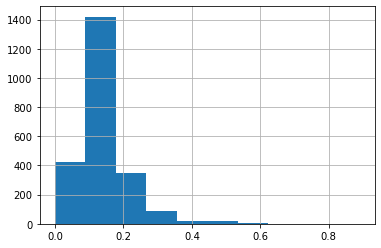

In [513]:
male_mean_hist = plt.hist(male_mean.values)
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_percentage_toxicity_male.jpg')

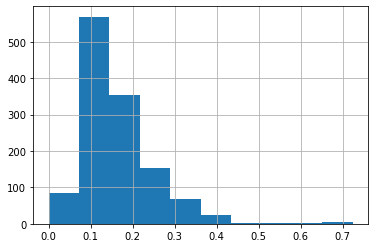

In [514]:
female_mean_hist = plt.hist(female_mean.values)
plt.grid()

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('hist_percentage_toxicity_female.jpg')

Finally, we apply a Statistical test to verify if the differences between the scores given by males and females is statistically significant. 

We use the Mannwithney test and our hypothesis is that females give more toxic scores than males. 

<b>H0: Females give fewer (or as many) toxic labels than Males</b>
- Females <= Males

<b>H1: Females give a greater amount of toxic labels than Males</b>
- Females > Males

In [515]:
scipy.stats.mannwhitneyu( female_mean['toxicity'], male_mean['toxicity'], use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=1672116.5, pvalue=4.183220891362381e-12)

We get a p-value that is smaller than 0.05, therefore we reject the null hypothesis that females give fewer (or as many) toxic labels than males. 

Therefore, <b>it seems that females might give toxic labels more often than males. </b>

## Implications for Research

#### What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 

Based on our analysis, hostile speech directed towards females or non-binary people might be an issue. Most of the annotators were males and they seem to be less sensitive to toxic comments than non-male annotators. This might bias models into overlooking content that is offensive to the genders that were less represented in this dataset.

Hostile speech with more English sophistication (or that requires English-centric cultural background to understand) might be harder to accurately detect due to the unbalace between native and non-native speakers annotators.  

#### What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

A potential unintended negative consequence of using Perspective API might be exposing users only to toxic comments that are (more) offensive to females and non-binary people. Because most of the labelers are male and they seem to be less sensitive than other genders, I assume that models will perform better in text with offensive comments to males (thus removing/erasing them); which will lead to the internet mostly having offensive comments to non-males. 

I think it is still a useful tool, but people using the API should be aware that this bias might happen; this way people using it can prepare psychologically instead of having a skewed vision of the internet. 

#### Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

I would try to balance the dataset based on gender of annotators (either by getting more annotator of the less represented genders or giving them more weight in my model). I would also explore more the reason why there are differences in the way different genders score toxicity.

I would also make sure to show a warning about the limitations of the model and provide a place for people to give feedback or input new toxic comments that were false negatives. 
